# Search, Information Retrieval, and Rcommender Systems 

## Final Course Project: Movie Recommender Systems

### Guy Gaash & Michael Rubinfeld

### Lecturer: Dr. Liron I. Allerhand

### Abstract

In this project we have built multiple recommender systems using 3 different approaches. One is a pure content-based recommender, recommending by cosine-similarity. The rest are learning model-based recommenders which performances in recommending will be compared.

### Problem Definition

Recommender systems are integral parts of retail and entertainment platforms. Now days, having a high-quality recommender system which fits the business goals, will probably increase sales, traffic or any KPI important to the business.
We are set to create a high-quality recommender system for recommending movies to clients.

##### Packges

In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
from pathlib import Path
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from datetime import datetime
import pickle
from tensorflow import keras
from keras.models import load_model
from typing import List, Any, Tuple
import warnings
warnings.filterwarnings('ignore')

In [2]:
ratings_df = pd.read_csv('ratings.csv')
movies_df = pd.read_csv('movies.csv')

#Covert timestamp str to a datetime object
ratings_df['timestamp'] = pd.to_datetime(ratings_df['timestamp'])

# Sort df by rating timestamp
ratings_df = ratings_df.sort_values(by=['timestamp'])

### The Dataset

We have used the “MovieLens 1M” dataset. We had downloaded it from MovieLens and used it locally. MovieLens is actually a collective of datasets but the core data we had needed for building the recommender systems is in the “ratings” and “movies” datasets.

* “ratings”: (user ID, movie ID, rating, timestamp)

* “movies”: (movie ID, movie name, genres)

* Its key to note that each movie is described by using one or more genres, we will use that fact later on

#### Preprocessing
* transform the timestamp column to timestamp objects. This is important for the splits later on
* Create two dictionaries, giving each unique user a number and giving each movie a number. Doing this had two reasons; First, is to simplify the work with the IDs. Second, to use the mapping from users and movies to thier counted indices to make the prediction later on more efficient

In [3]:
movies_df.head()

movieId                               title                        genres
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy

In [4]:
ratings_df.head()

userId  movieId  rating           timestamp
985825    5954     2297       3 2000-01-05 00:03:00
986067    5954     3390       1 2000-01-05 00:03:00
985965    5954     2327       2 2000-01-05 00:03:00
985491    5954     1198       4 2000-01-05 00:03:00
985842    5954     3263       1 2000-01-05 00:04:00

### Data Exploration

In [5]:
print("======= General Statistics =======\n")
print("Number of rating entries:", ratings_df.shape[0])
print(f"Mean rating: {ratings_df['rating'].mean():.2f}")
print("Number of movies:", movies_df.shape[0], "\n")
print("==================================")

======= General Statistics =======

Number of rating entries: 1000209
Mean rating: 3.58
Number of movies: 3883 



In [6]:
fig = go.Figure(data=[go.Bar(
            x=movies_df['genres'].value_counts().index[0:15], y=movies_df['genres'].value_counts().values[0:15],
            text=movies_df['genres'].value_counts().values[0:15],
            textposition='outside')])
fig.update_layout(title = 'Movie Genres in the Dataset', title_x=0.5)

fig.show()

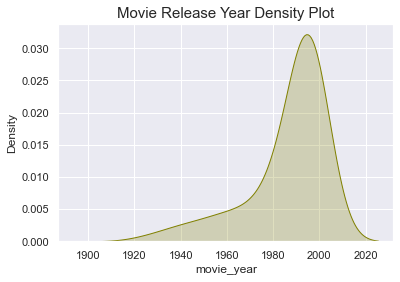

In [7]:
movies_df['movie_year'] = movies_df['title'].str[-5:-1]
movies_df.movie_year = movies_df.movie_year.map(lambda x: int(x))

sns.set(style="darkgrid")
sns.kdeplot(movies_df.movie_year, shade=True, bw=0.5, color="olive")
plt.title("Movie Release Year Density Plot", fontsize=15)
plt.show()

In [8]:
user_ratings_df = ratings_df[['userId', 'rating']]
train_user_avg = user_ratings_df.groupby('userId', as_index=False).mean()
print(train_user_avg)

      userId    rating
0          1  4.188679
1          2  3.713178
2          3  3.901961
3          4  4.190476
4          5  3.146465
...      ...       ...
6035    6036  3.302928
6036    6037  3.717822
6037    6038  3.800000
6038    6039  3.878049
6039    6040  3.577713

[6040 rows x 2 columns]


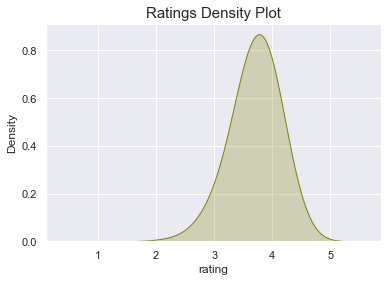

In [9]:
# Ratings Density Plot
sns.set(style="darkgrid")
sns.kdeplot(train_user_avg['rating'], shade=True, bw=0.5, color="olive")
plt.title("Ratings Density Plot", fontsize=15)
plt.show()

### Metrics used to evaluate performance

It made more sense to us to treat the prediction of the scores that will be given by users as a regression problem.
We chose the regression metric MSE. We trained the model using MSE loss so we used it as a metric and measured the models’ performance on how well they have lowered the validation MSE loss. 

##### Matrix Factorization Model Load

In [11]:
MF_model = load_model("final_mf_model")

2022-01-07 12:31:56.391474: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


##### Content Based Model Load

In [12]:
CB_model = load_model("final_cb_model")

### Train, Validation, Test Split

We split ratings_df to train (64%), validation (16%), test sets (20%).

Before splitting, we sorted the data by timestamp so the rating times will be train then validation then test. This step is improtant because:
1. We assume that ratings are affected by the zeitgeist
2. A recommender system learns from historical data to recommend in the present, so we wanted the model to have this notion

In [13]:
SPLIT_RATE = 0.8    # 80% of the data for train 20% for test. 20% of the remaining train data will go to validation

# create one dictionary mapping userId to userId count in the dataframe and the other does the opposite
user_ids = ratings_df["userId"].unique().tolist()
userId_to_usercount_dict = {x: i for i, x in enumerate(user_ids)}
usercount_to_userId_dict = {i: x for i, x in enumerate(user_ids)}

# create one dictionary mapping movieId to movieId count in the dataframe and the other does the opposite
movie_ids = ratings_df["movieId"].unique().tolist()
movieId_to_moviecount_dict = {x: i for i, x in enumerate(movie_ids)}
moviecount_to_movieId_dict = {i: x for i, x in enumerate(movie_ids)}

# create features of the mapped users and movies
ratings_df["user"] = ratings_df["userId"].map(userId_to_usercount_dict)
ratings_df["movie"] = ratings_df["movieId"].map(movieId_to_moviecount_dict)

# Split to data and label
X = ratings_df[["user", "movie"]].values
y = ratings_df["rating"].values

# split to train, validation and test
train_val_indices = int(SPLIT_RATE * X.shape[0])
X_train_val, X_test, y_train_val, y_test = (
    X[:train_val_indices],
    X[train_val_indices:],
    y[:train_val_indices],
    y[train_val_indices:],
)

train_indices = int(SPLIT_RATE * X_train_val.shape[0])
X_train, X_val, y_train, y_val = (
    X_train_val[:train_indices],
    X_train_val[train_indices:],
    y_train_val[:train_indices],
    y_train_val[train_indices:],
)

### Baselines:

We chose two different kinds of baselines to compare the peformace of our methods:
1. Models' MSEs - we wanted to see if our model can learn and do better than non-learning methods. If the learning proccess did not achive better MSE ther eis no reason to use a learning model
2. Models' Recommendations - this is a sobejctive baseline. We used it to see if using more advanced method than just recommending the most popular movies will subjectively give better recommendations

### 1. Recommendation Baseline

Meaning: blindely recommend the 10 movies with the highest average rating 

In [14]:
movie_ratings_df = ratings_df[['movieId', 'rating']]
movie_means_df = movie_ratings_df.groupby('movieId', as_index=False).mean()
top_movies_df = movie_means_df.sort_values(by=['rating'], ascending = False)[:10]
top_movies_df = top_movies_df.reset_index(drop = True)
top_movies_df = pd.merge(top_movies_df, movies_df, on='movieId')
top_movies_df = top_movies_df[['title', 'rating']].iloc[:, 0].to_frame()

top_movies_df

title
0  Schlafes Bruder (Brother of Sleep) (1995)
1                   Bittersweet Motel (2000)
2                    Follow the Bitch (1998)
3                     Song of Freedom (1936)
4         Gate of Heavenly Peace, The (1995)
5                           Baby, The (1973)
6                   One Little Indian (1973)
7                       Smashing Time (1967)
8                    Ulysses (Ulisse) (1954)
9                               Lured (1947)

### 2. MSEs Baseline

We used several baselines for the MSE; the most basic one is just the global average of the training set.
A more advanced baseline, are calculating the MSE on the validation and test sets using averages from the training set only.
We calculated the MSE in three variations: using user average, using movie average, using both.
(calculation done seperately, results were pickled and loaded to this notebook)

In [15]:
with open('mse_bias_claculations.pickle', 'rb') as handle:
    mse_bias_claculations_dict = pickle.load(handle)
mse_bias_claculations_df = pd.DataFrame.from_dict(mse_bias_claculations_dict, orient='index')
mse_bias_claculations_df

0
global_bias          3.607169
val_user_mse         1.524889
val_movie_mse        1.753442
val_user_movie_mse   1.911230
test_user_mse        1.453587
test_movie_mse       1.658009
test_user_movie_mse  1.787937

### Moodels Used

We used two main methods for biulding a recommendation systems - Matrix Factorization and Content Based (with two approches)

##### Matrix Factorization
* We used the calissical MF approach as taught in class. 
* We used embedding layers for users and movies with the same embedding dimension
* We Initialized two embedding layers to represent user and movie biases

##### Content Based

Our approach is to use movie similarity while recommeding with the Content Based model.
In our case movie similarity means recommending based on the movie genres
Most movies are represnted by more than one genre, we wanted to take advantage of it and to represent each movie by all its possible genre combinations (well, not all of them that’s a hyperparameter).

We will use this approach to build two Content Based recommenders:
##### Recommending by cosine similarity
* prints recommendation only (accuracy cannot be measured)

##### Recommending by content-based learning model
* uses an embeding matrix which represnts the genres combination


##### MF Test Predict

In [16]:
y_pred = MF_model.predict(X_test)
print(keras.losses.mean_squared_error(y_test, y_pred))

tf.Tensor(0.9537875, shape=(), dtype=float32)


##### CB Test Predict

In [17]:
y_pred = CB_model.predict(X_test)
print(keras.losses.mean_squared_error(y_test, y_pred))

tf.Tensor(0.9694175, shape=(), dtype=float32)


#### Models’ Results Comparison

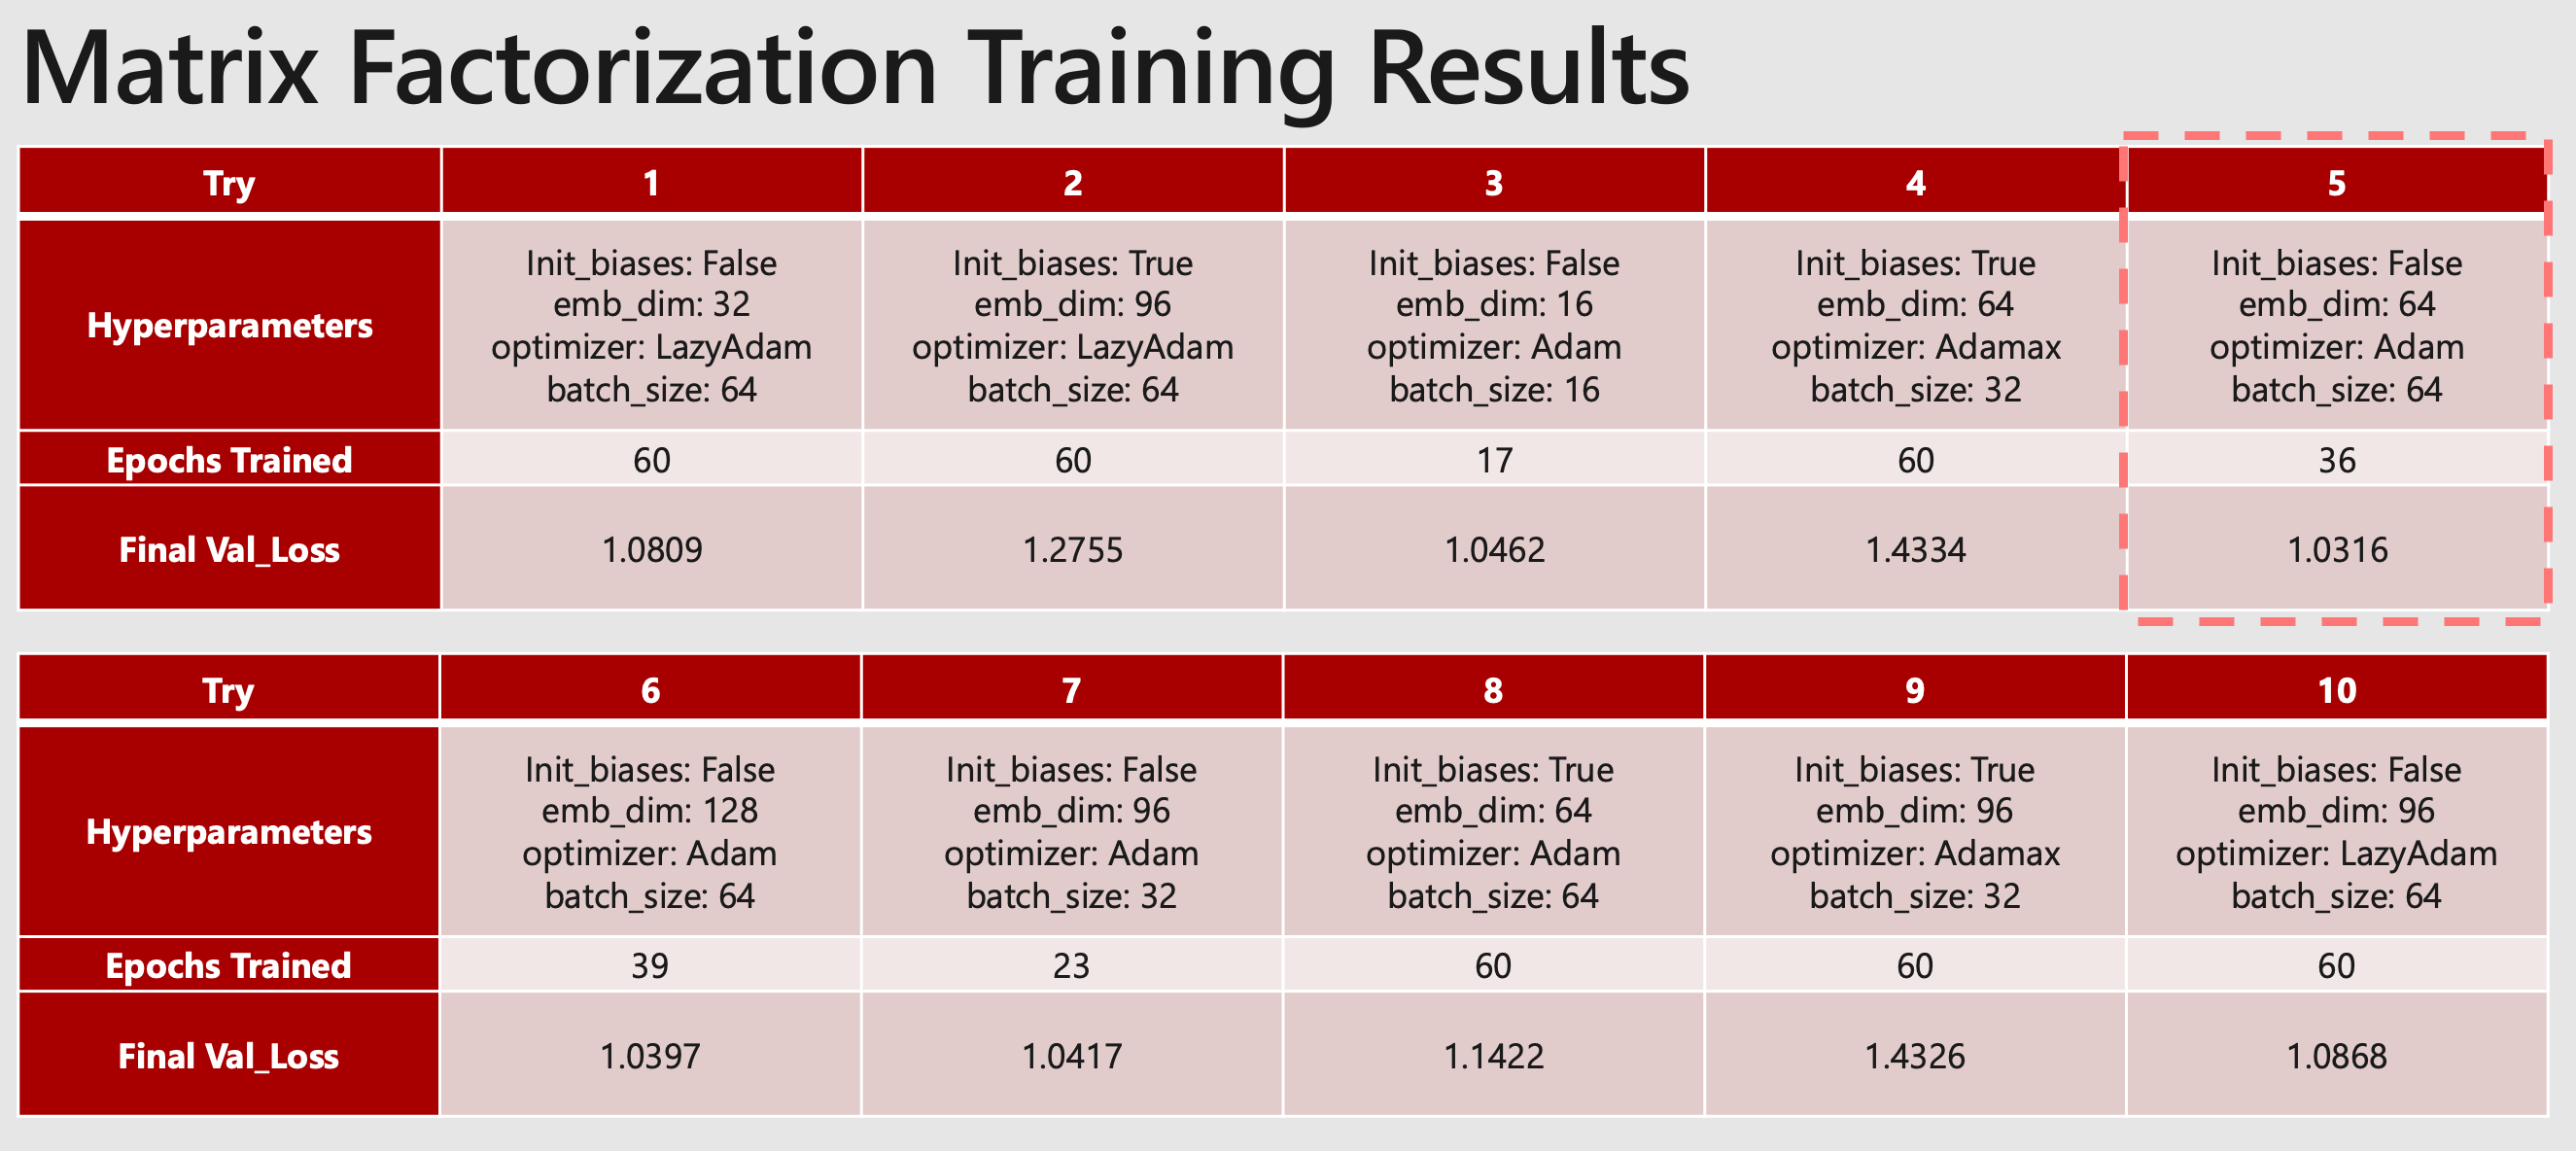

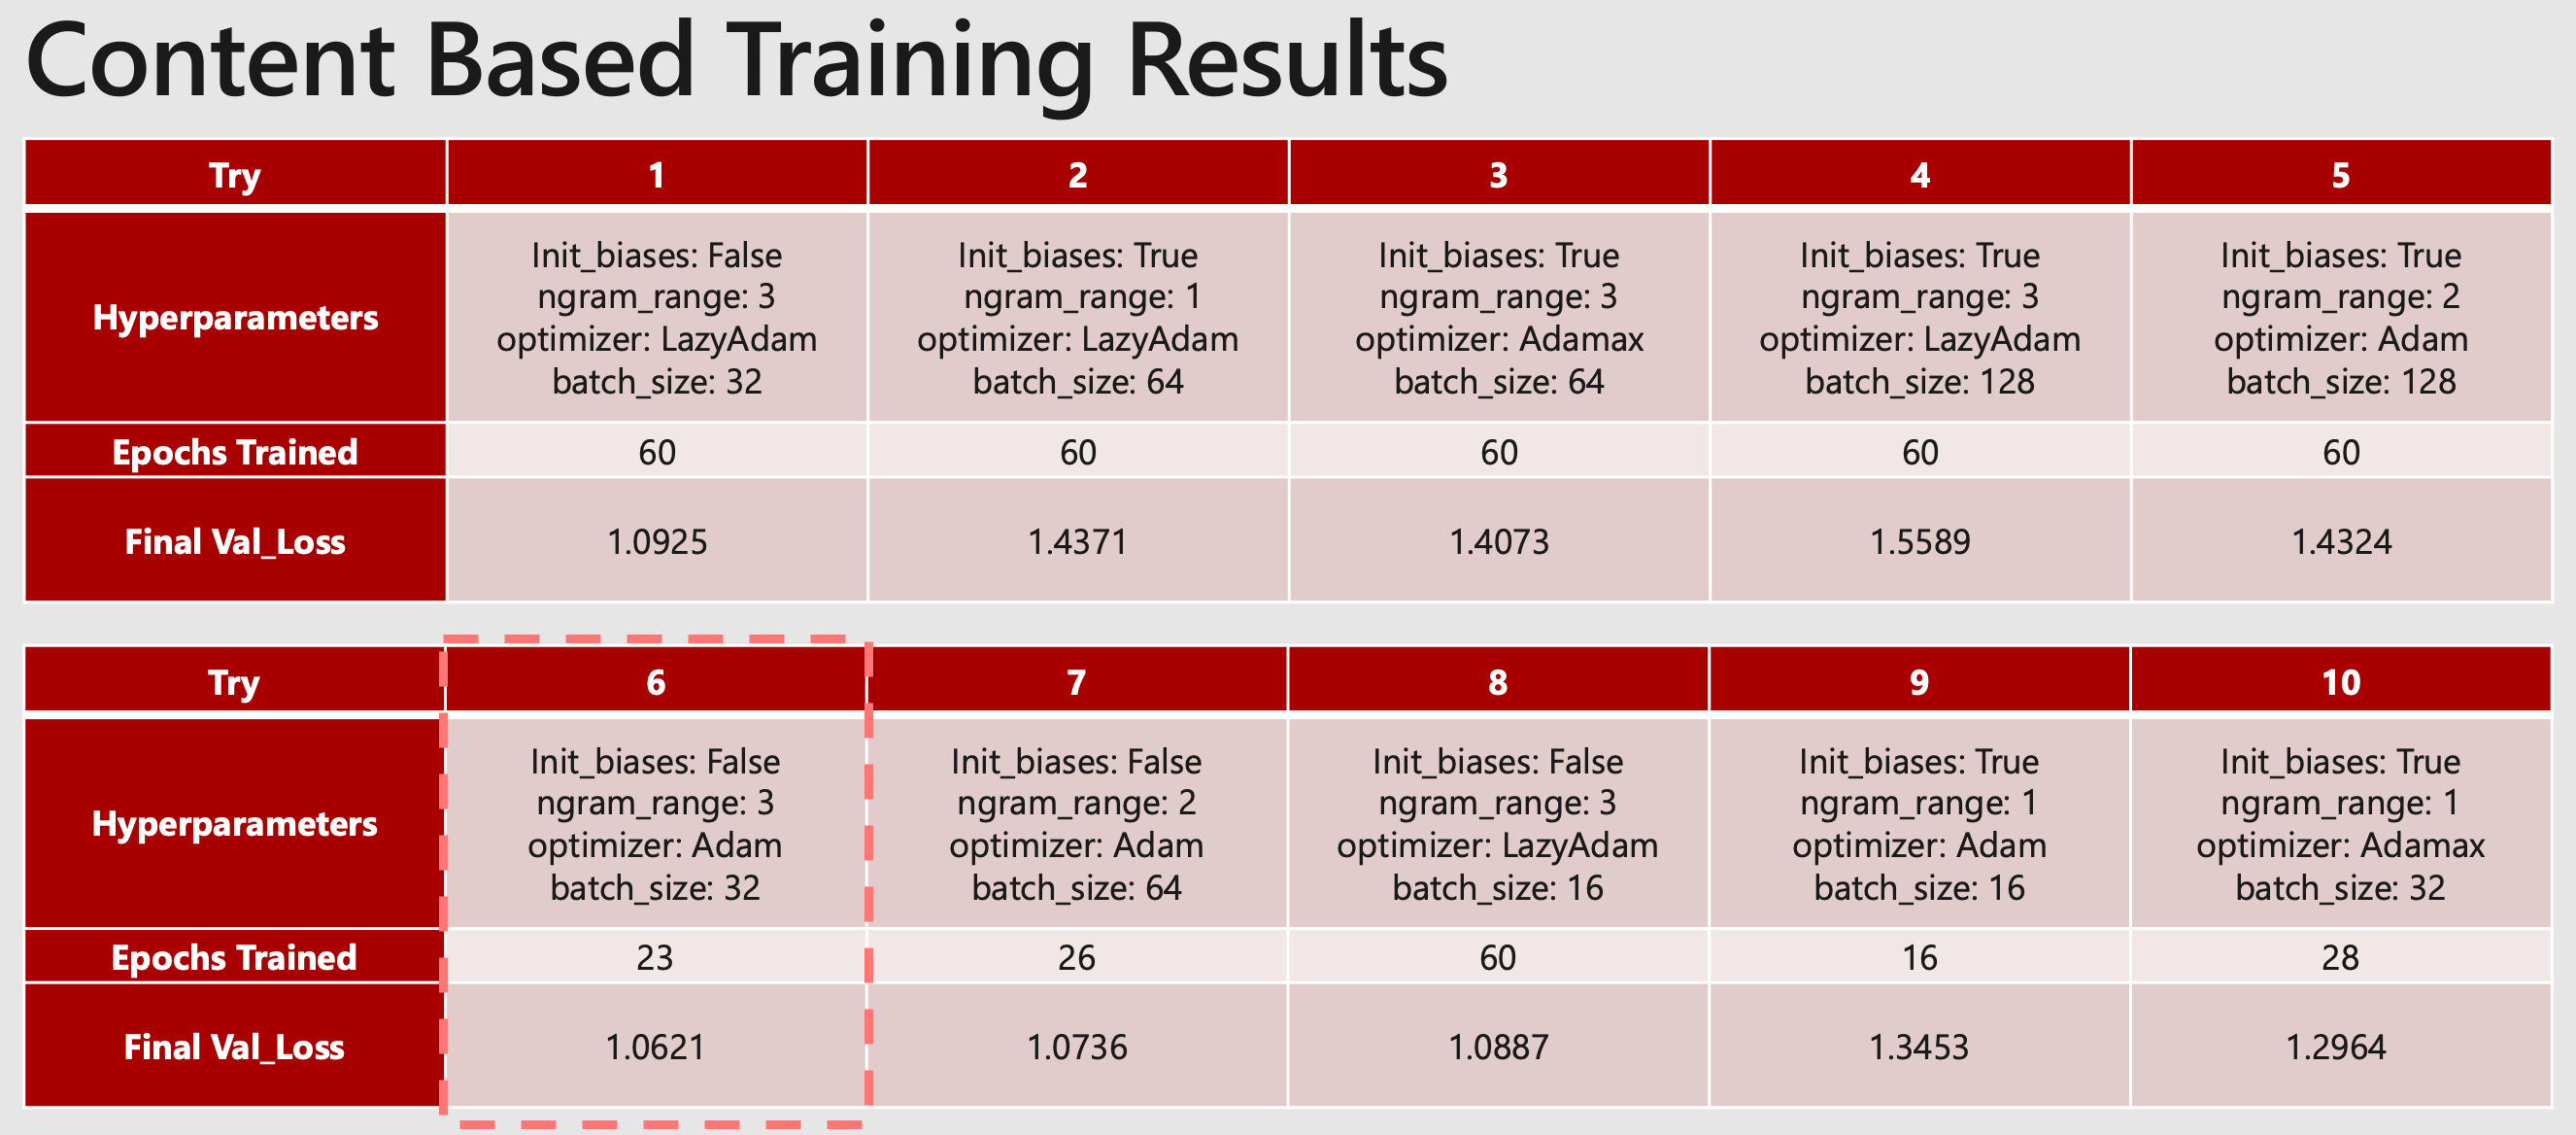

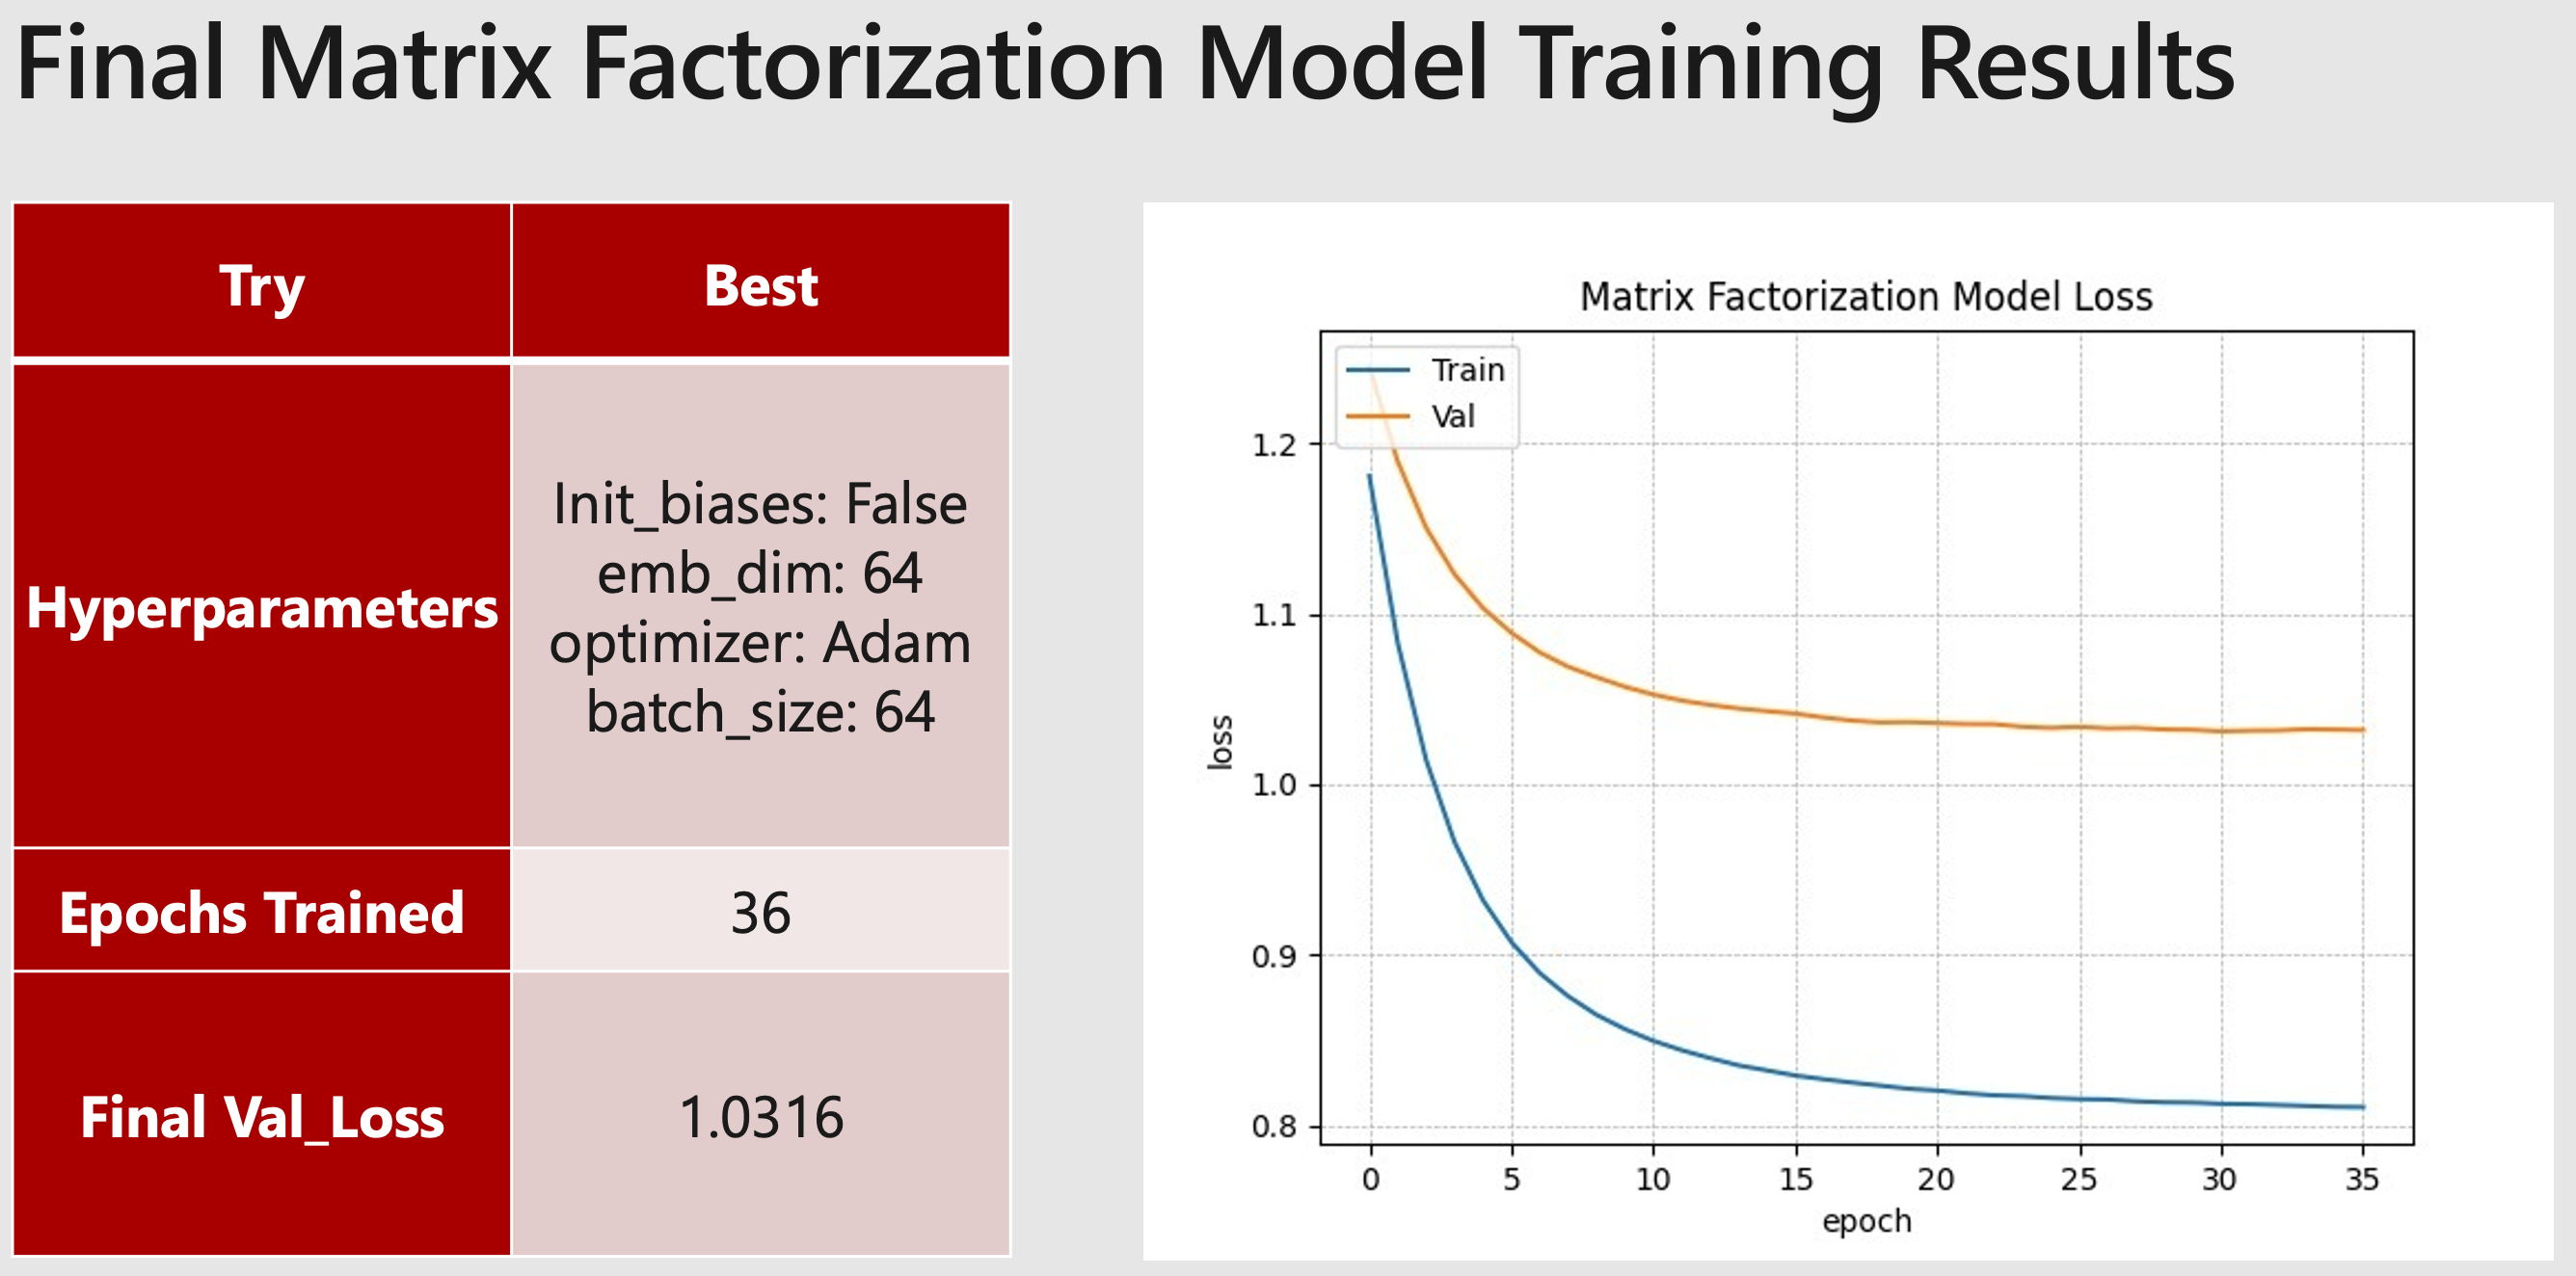

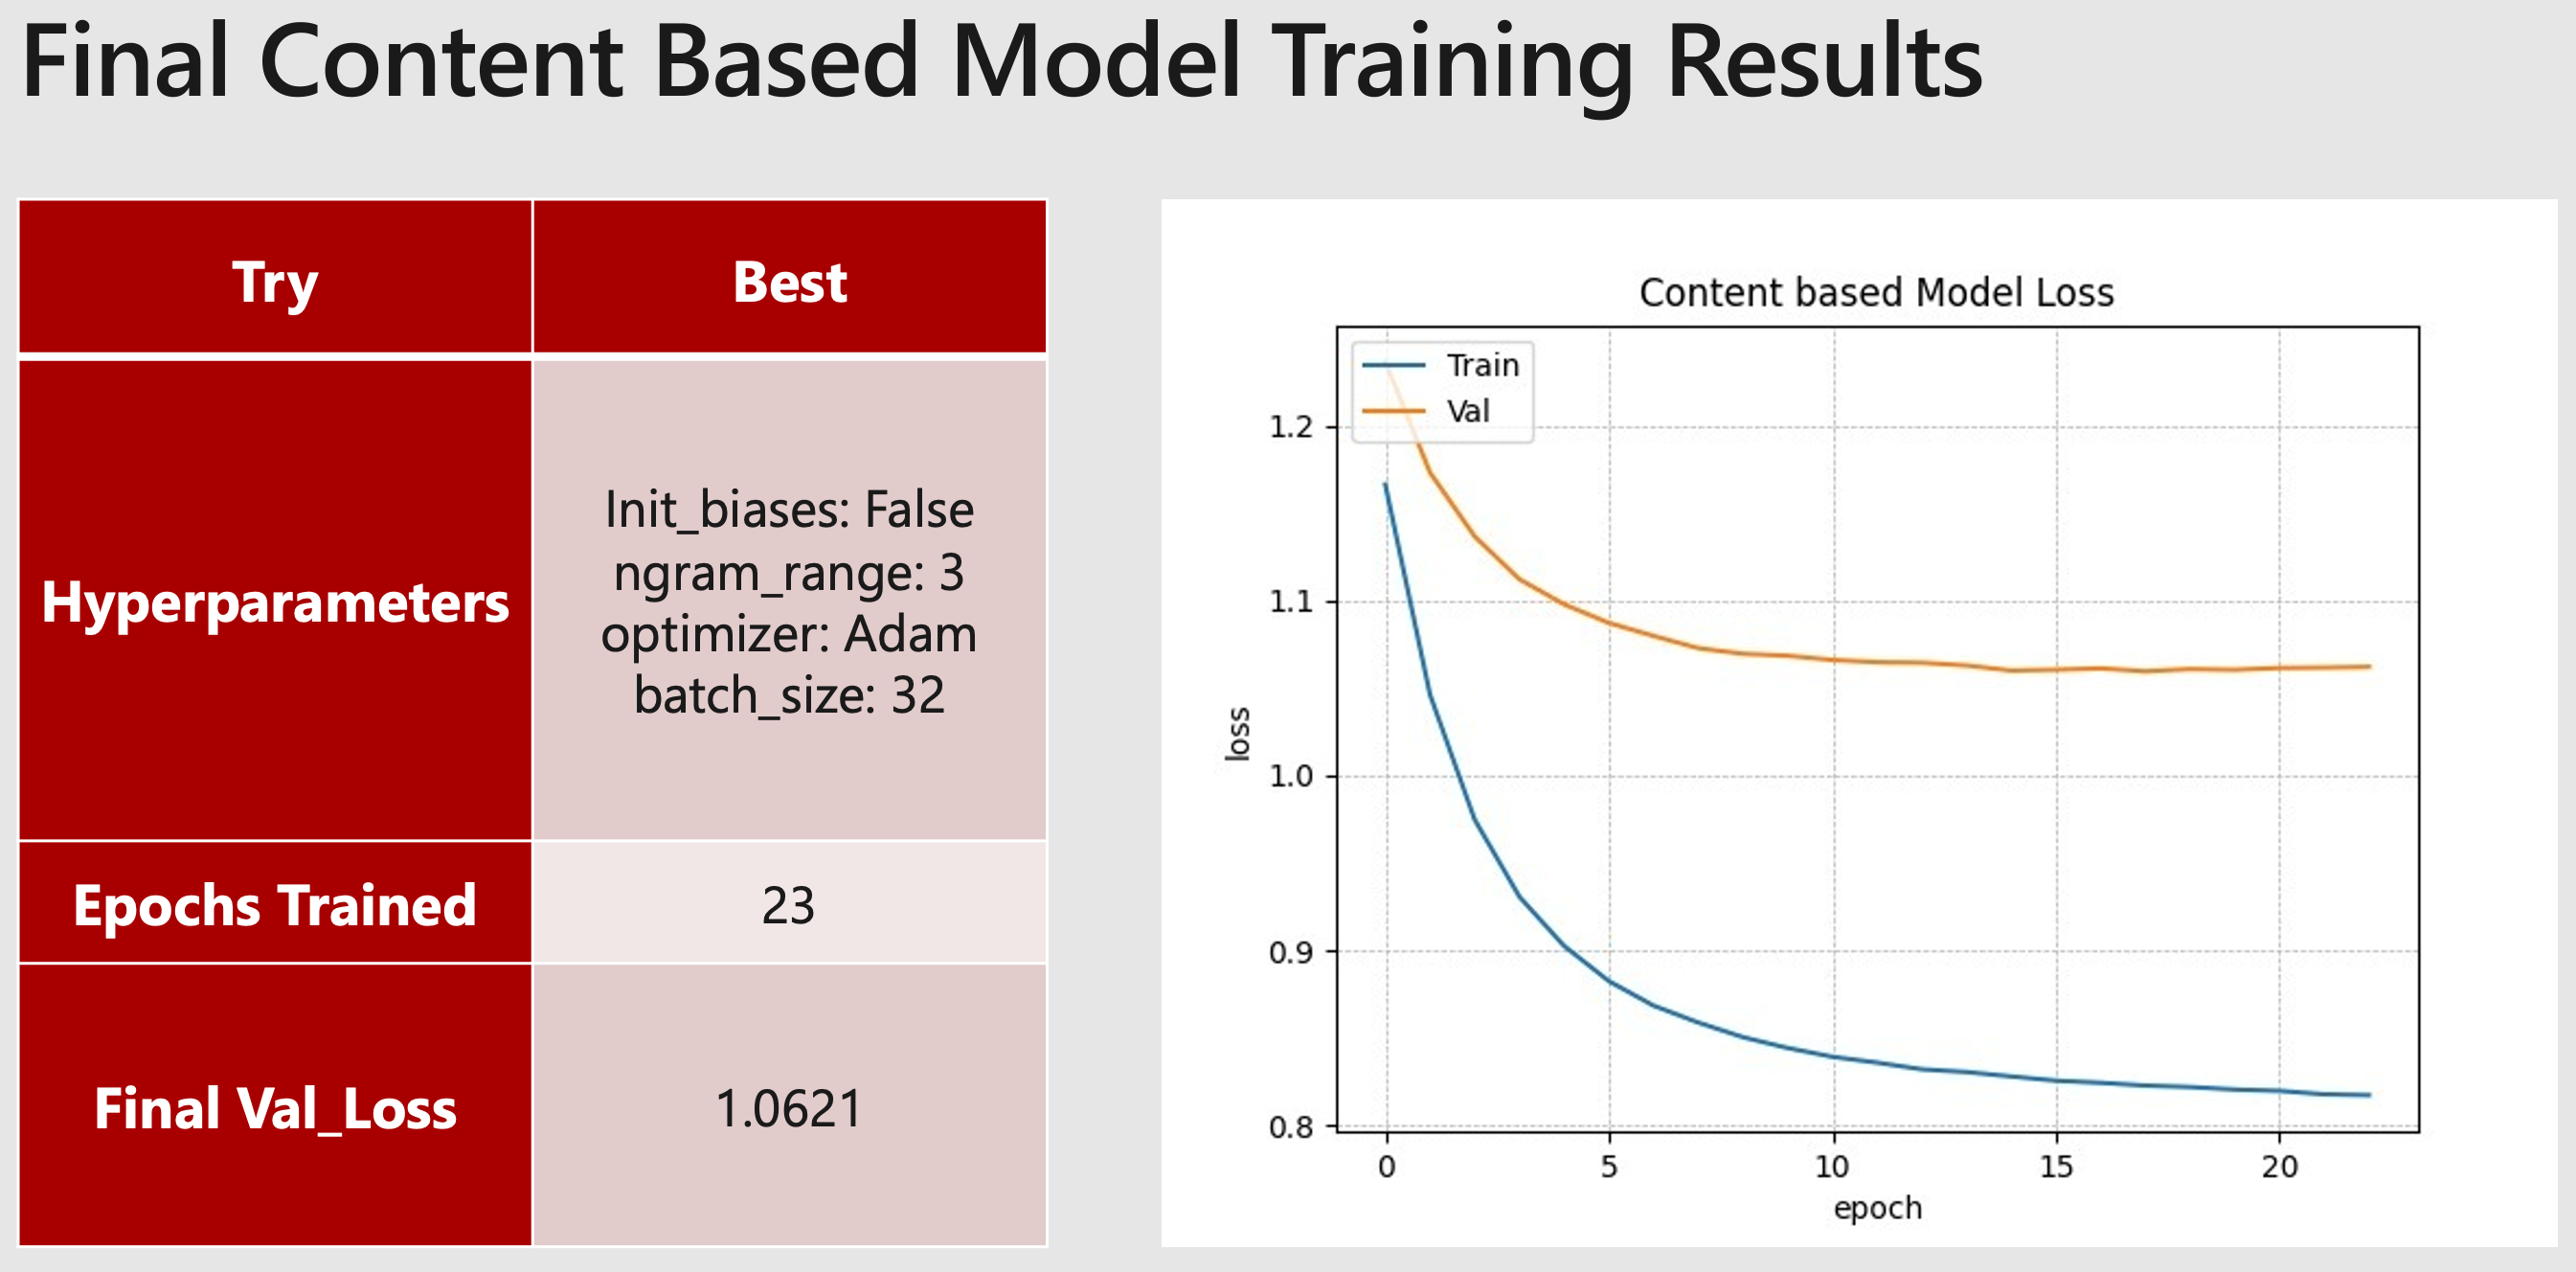

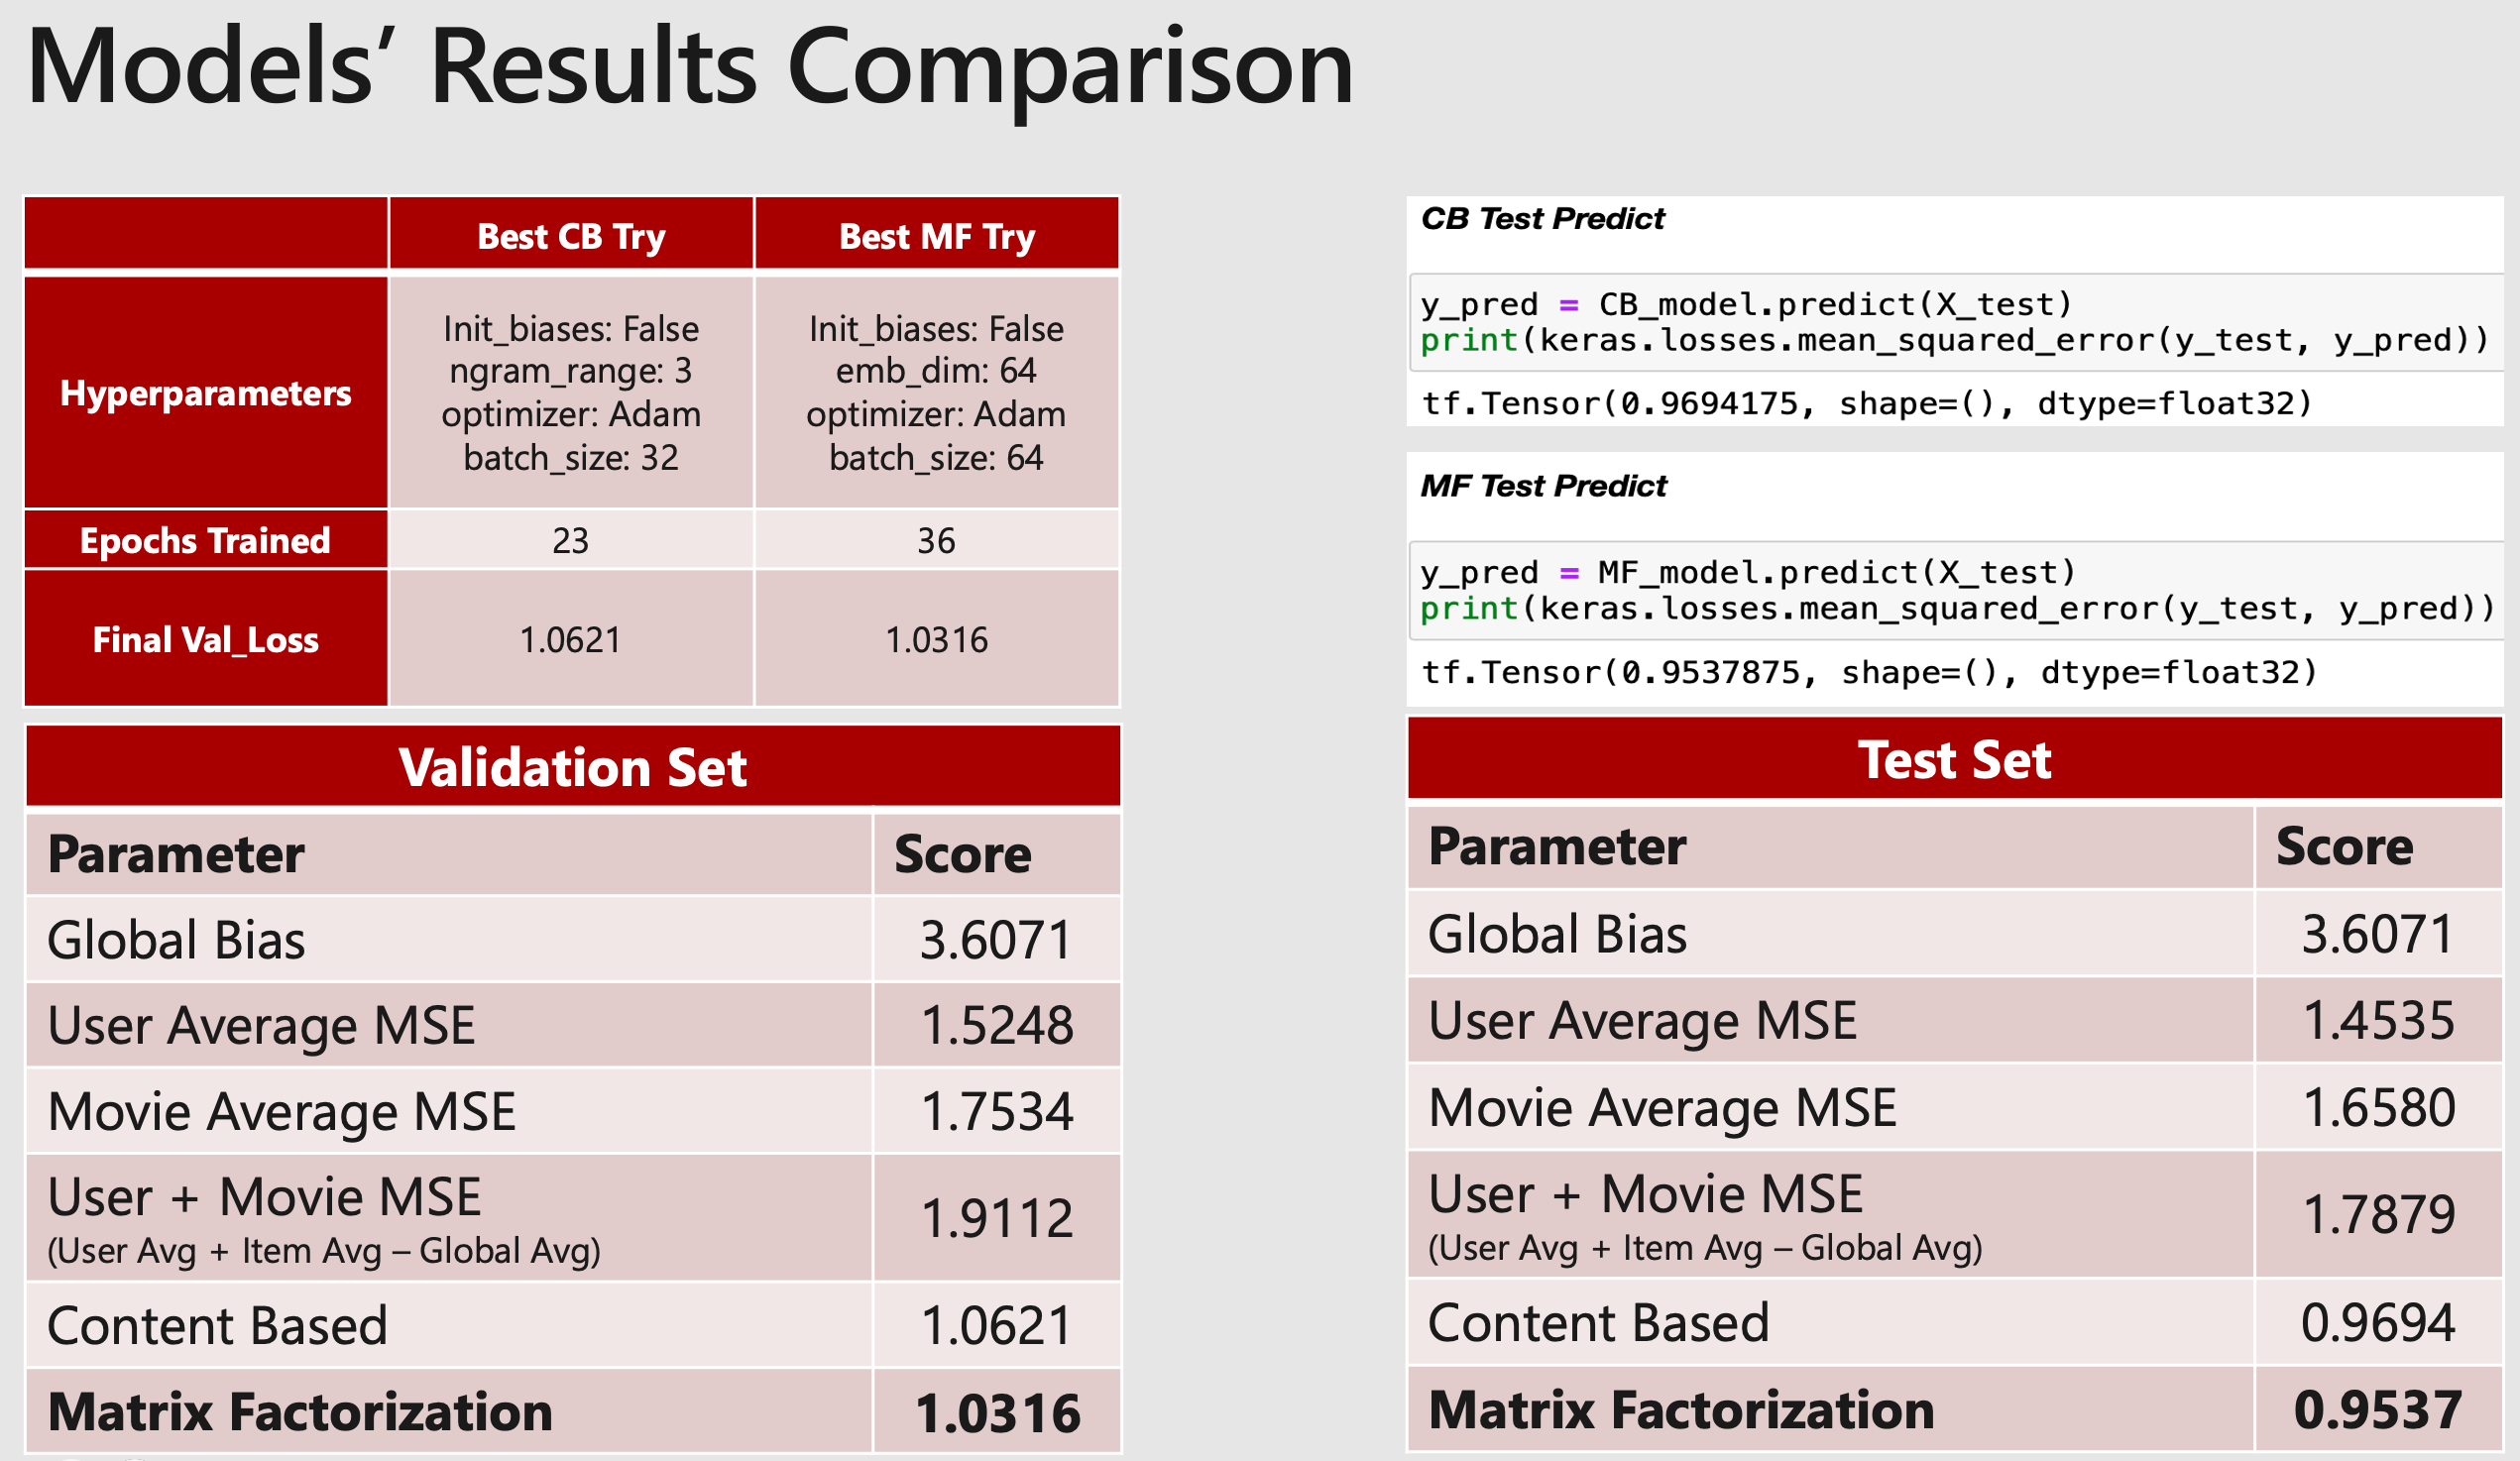

### Movies Recommendations Based on Cosine Similarity, CB Model, and MF

#### Recommendation Baseline Reminder

In [18]:
top_movies_df

title
0  Schlafes Bruder (Brother of Sleep) (1995)
1                   Bittersweet Motel (2000)
2                    Follow the Bitch (1998)
3                     Song of Freedom (1936)
4         Gate of Heavenly Peace, The (1995)
5                           Baby, The (1973)
6                   One Little Indian (1973)
7                       Smashing Time (1967)
8                    Ulysses (Ulisse) (1954)
9                               Lured (1947)

#### Cosine-Similarity Recommendation Results Based on the Top 5 Favorite Movies of User '767' 

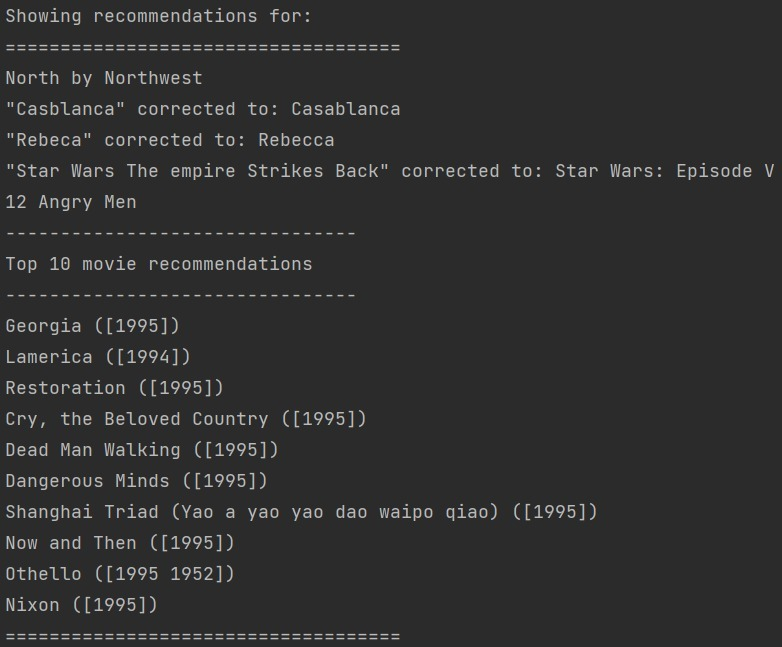

#### CB Recommendation Results

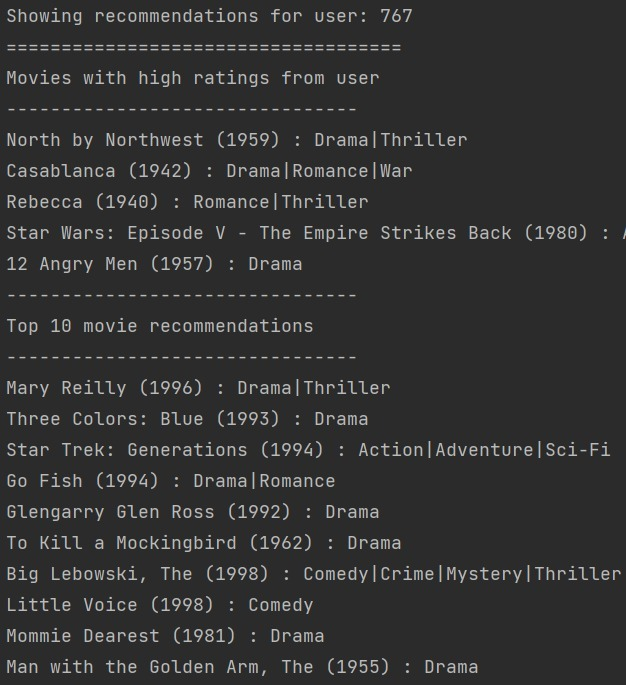

#### MF Recommendation Results

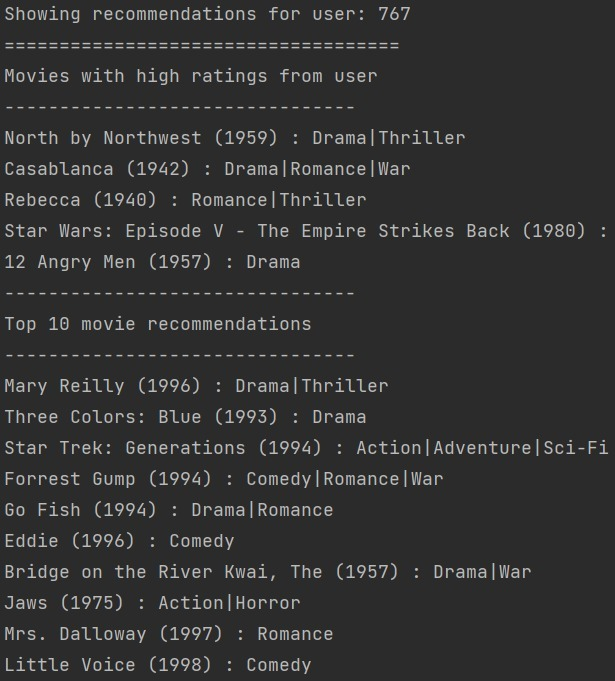

### Conclusions

1. The models have learned succefully and did better than non-learning methods comparing to the MSE and reecommendation baselines 
2. The best model was MF with 0.9357 MSE score on the test set.
3. In theory, bias initialization should improve the models' results. Here we see that the best results in both models had no bias initializations, and overall models who had bias initialization would probably do worse. An explanation for that, is that our bias initialization wasn't accurate enough.
4. The best CB model used tri-grams of genre combinations. The most succesful tries used bi-grams or tri-grams. (we cannot conclude that using more than uni-grams will always do better)